# **Import Library** 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

import joblib

import warnings
warnings.filterwarnings('ignore')

# **Data Gathering** 

In [35]:
tourism_df = pd.read_csv('../data/tourism_with_id.csv')

# **Data Cleaning**

In [36]:
tourism_df = tourism_df.drop(columns=['Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'])

# **Exploratory Data Analysis** 

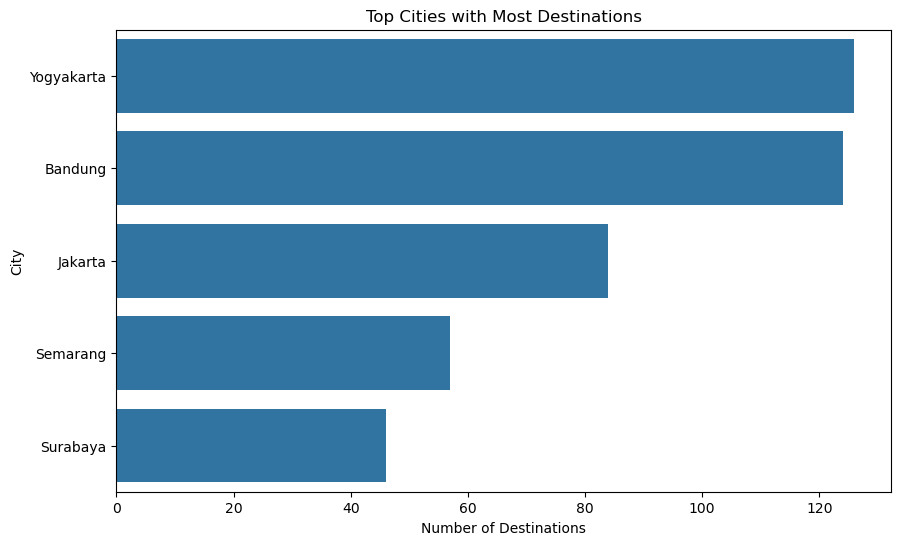

In [37]:
# 1. Top Cities with Most Destinations
city_count = tourism_df['City'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=city_count.values, y=city_count.index)
plt.title('Top Cities with Most Destinations')
plt.xlabel('Number of Destinations')
plt.ylabel('City')
plt.show()

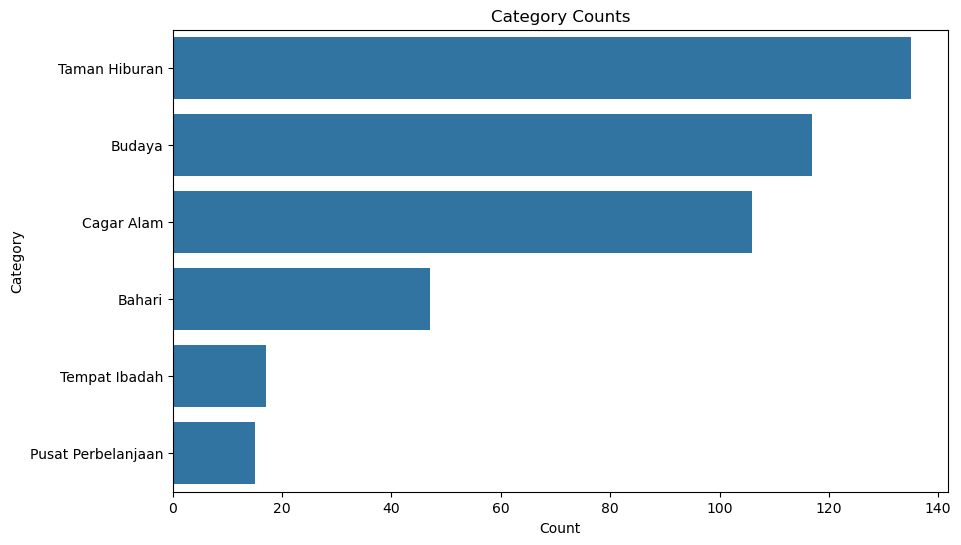

In [38]:
# 2. Category Counts
category_count = tourism_df['Category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_count.values, y=category_count.index)
plt.title('Category Counts')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# **Content-Based Filtering Model** 

### Data Preparation 

In [39]:
def prepare_features(df):
    # Tambahkan fitur baru
    df['name_word_count'] = df['Place_Name'].str.count('\w+')
    
    # Buat price categories
    df['price_category'] = pd.qcut(df['Price'], q=3, labels=['low', 'medium', 'high'])
    
    # Kombinasikan fitur
    df['combined_features'] = df.apply(lambda row: 
        f"{row['Place_Name']} {row['City']} {row['Description']} {row['price_category']} {row['name_word_count']}",
        axis=1
    )
    
    return df

### Data Augmentation 

In [40]:
def augment_text(text, num_augmentations=2):
    augmented_texts = [text]
    
    # Tambahkan variasi dengan mengacak urutan kata
    words = text.split()
    for _ in range(num_augmentations):
        np.random.shuffle(words)
        augmented_texts.append(' '.join(words))
    
    return augmented_texts

### Data Processing 

In [41]:
tourism_df = prepare_features(tourism_df)

In [42]:
# Augmentasi data
augmented_texts = []
augmented_categories = []

In [43]:
for idx, row in tourism_df.iterrows():
    augmented_versions = augment_text(row['combined_features'])
    augmented_texts.extend(augmented_versions)
    augmented_categories.extend([row['Category']] * len(augmented_versions))

In [44]:
# Konversi ke DataFrame
augmented_df = pd.DataFrame({
    'combined_features': augmented_texts,
    'Category': augmented_categories
})

In [45]:
# Proses TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(augmented_df['combined_features']).toarray()

In [46]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(augmented_df['Category'])
y_onehot = tf.keras.utils.to_categorical(y)

In [47]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [48]:
# Normalisasi input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# build model
def build_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Dense(512, input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.4),
        
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [50]:
# Inisialisasi dan compile model
input_dim = X_train_scaled.shape[1]
num_classes = y_train.shape[1]
model = build_model(input_dim, num_classes)

In [51]:
# Training
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3129 - loss: 1.8284 - val_accuracy: 0.8095 - val_loss: 0.8549
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7583 - loss: 0.8331 - val_accuracy: 0.8714 - val_loss: 0.4253
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9136 - loss: 0.3682 - val_accuracy: 0.9143 - val_loss: 0.2505
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9510 - loss: 0.2156 - val_accuracy: 0.9286 - val_loss: 0.1874
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9881 - loss: 0.1163 - val_accuracy: 0.9333 - val_loss: 0.1664
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9906 - loss: 0.0826 - val_accuracy: 0.9286 - val_loss: 0.1619
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9975 - loss: 0.0584 - val_accuracy: 0.9381 - val_loss: 0.1467
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9957 - loss: 0.0417 - val_accuracy: 0.9286 - 

In [52]:
# 6. Evaluasi
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.2398 

Test accuracy: 0.9506


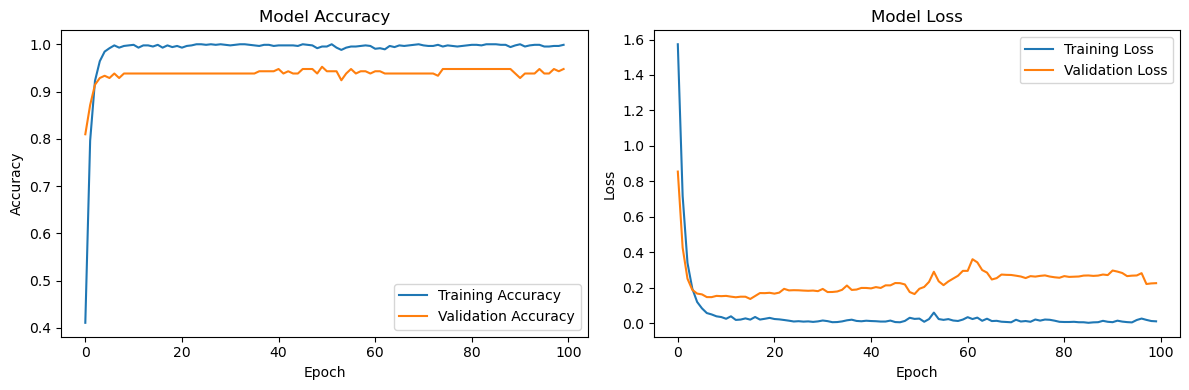

In [53]:
# 7. Plot hasil training
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


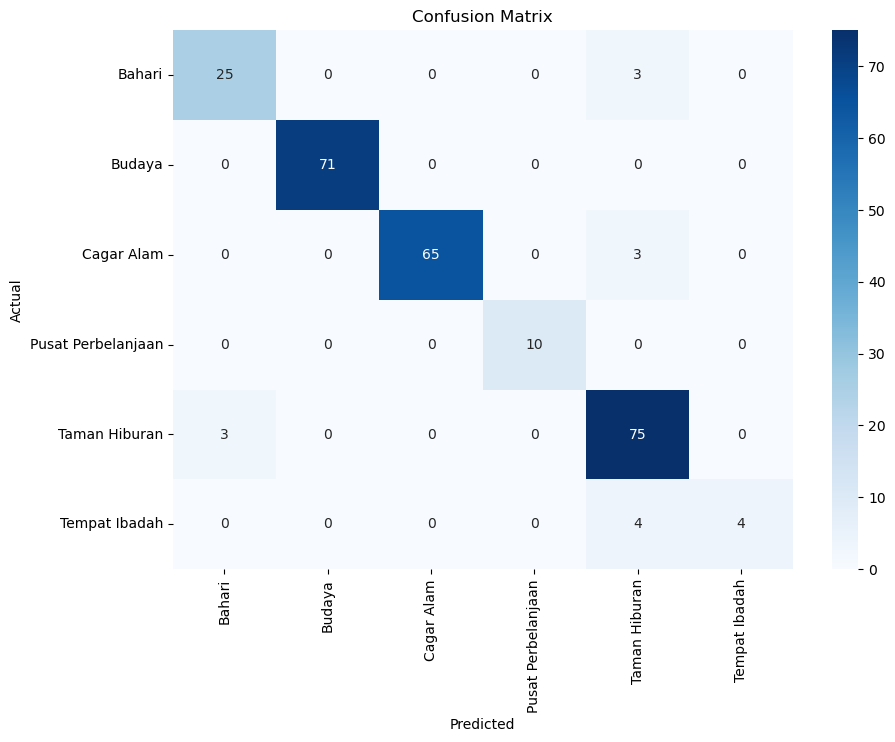

In [54]:
# Prediksi
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1) 

# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Menghitung jumlah prediksi benar dan salah
correct_predictions = np.sum(np.diag(conf_matrix))
total_predictions = np.sum(conf_matrix)
incorrect_predictions = total_predictions - correct_predictions

print(f"Total tempat wisata yang diprediksi: {total_predictions}")
print(f"Tempat wisata yang diprediksi dengan benar: {correct_predictions}")
print(f"Tempat wisata yang diprediksi salah: {incorrect_predictions}")

Total tempat wisata yang diprediksi: 263
Tempat wisata yang diprediksi dengan benar: 250
Tempat wisata yang diprediksi salah: 13


In [56]:
def predict_category(model, tfidf_vectorizer, scaler, label_encoder, place_name):
    # Membuat feature yang sama seperti data training
    name_word_count = len(place_name.split())
    
    combined_features = f"{place_name}  {name_word_count}"
    
    # Transformasi input menggunakan TF-IDF
    input_vector = tfidf_vectorizer.transform([combined_features]).toarray()
    
    # Normalisasi input menggunakan scaler yang sama dengan training
    input_scaled = scaler.transform(input_vector)
    
    # Lakukan prediksi
    prediction = model.predict(input_scaled)
    
    # Dapatkan probabilitas untuk setiap kategori
    probabilities = prediction[0]
    predicted_category_index = np.argmax(probabilities)
    predicted_category = label_encoder.inverse_transform([predicted_category_index])[0]
    
    # Tampilkan probabilitas untuk setiap kategori
    categories = label_encoder.classes_
    for cat, prob in zip(categories, probabilities):
        print(f"{cat}: {prob:.4f}")
    
    return predicted_category

In [75]:
# Contoh penggunaan:
input_place = "Pasar Beringharjo"

predicted_category = predict_category(
    model=model,
    tfidf_vectorizer=tfidf_vectorizer,
    scaler=scaler,
    label_encoder=label_encoder,
    place_name=input_place,
)

print(f"\nFinal Prediction for {input_place}: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Bahari: 0.0737
Budaya: 0.0279
Cagar Alam: 0.0113
Pusat Perbelanjaan: 0.4453
Taman Hiburan: 0.0718
Tempat Ibadah: 0.3700

Final Prediction for Pasar Beringharjo: Pusat Perbelanjaan


In [58]:
def get_recommendations(place_name, tourism_df, model, tfidf_vectorizer, scaler, label_encoder, n_recommendations=20):
    # Cari tempat wisata di dataset
    input_place = tourism_df[tourism_df['Place_Name'].str.lower() == place_name.lower()]
    
    predicted_category = predict_category(
        model=model,
        tfidf_vectorizer=tfidf_vectorizer,
        scaler=scaler,
        label_encoder=label_encoder,
        place_name=place_name
    )
    print(f"Kategori: {predicted_category}")
    category = predicted_category
    
    # Filter tempat wisata dengan kategori yang sama
    similar_places = tourism_df[tourism_df['Category'] == category].copy()
    
    # Hapus tempat wisata input dari rekomendasi jika ada
    if not input_place.empty:
        similar_places = similar_places[similar_places['Place_Name'] != place_name]
    
    # Urutkan tempat wisata berdasarkan nama atau kriteria lain
    recommendations = similar_places.sort_values(by='Place_Name').head(n_recommendations)
    
    # Format output
    output_recommendations = recommendations[[
        'Place_Name', 'Category', 'City', 'Price', 'Description',
    ]].copy()
    
    return output_recommendations

In [76]:
# Contoh penggunaan:
input_place = "Candi Borobudur"
recommendations = get_recommendations(
    place_name=input_place,
    tourism_df=tourism_df,
    model=model,
    tfidf_vectorizer=tfidf_vectorizer,
    scaler=scaler,
    label_encoder=label_encoder,
    n_recommendations=15
)

print("\nRekomendasi tempat wisata serupa:")
for idx, row in recommendations.iterrows():
    print(f"\n{row['Place_Name']} ({row['City']})")
    print(f"Kategori: {row['Category']}")
    print(f"Harga: Rp {row['Price']:,}")
    print(f"Deskripsi: {row['Description'][:200]}...")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Bahari: 0.0003
Budaya: 0.9932
Cagar Alam: 0.0031
Pusat Perbelanjaan: 0.0000
Taman Hiburan: 0.0033
Tempat Ibadah: 0.0001
Kategori: Budaya

Rekomendasi tempat wisata serupa:

Alun-alun Utara Keraton Yogyakarta (Yogyakarta)
Kategori: Budaya
Harga: Rp 0
Deskripsi: Alun-alun utara atau dalam Bahasa Jawa disebut Alun-alun Lor merupakan salah satu land mark Kota Yogyakarta yang berupa sebuah tanah lapang yang berada di depan Keraton Yogyakarta. Disebut Alun-alun L...

Amazing Art World (Bandung)
Kategori: Budaya
Harga: Rp 75,000
Deskripsi: Amazing Art World Bandung, sebuah objek wisata yang terletak di Bandung, yang menegaskan bahwa destinasi wisata itu bukan hanya sekedar tentang pantai, air terjun, atau wisata alam lainnya saja. Hasil...

Balai Kota Surabaya (Surabaya)
Kategori: Budaya
Harga: Rp 0
Deskripsi: Surabaya sebagai Resort Gemeente (Haminte) secara resmi mulai berdiri pada tanggal 1 April 1906. Sebelumnya Surabaya merupakan bagian dari kareside

<!-- # **Model Save** -->

In [60]:
# Simpan model dalam format H5
# model.save('../model/tourism_classifier.h5')

In [61]:
# Konversi ke TFLite untuk Android
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# with open('../model/tourism_classifier.tflite', 'wb') as f:
#     f.write(tflite_model)

In [62]:
# simpan label encoder
# joblib.dump(label_encoder, '../model/label_encoder.joblib')

In [63]:
# simpan vectorizer
# joblib.dump(tfidf_vectorizer, '../model/tfidf_vectorizer.joblib')

In [64]:
# simpan scaler
# joblib.dump(scaler, '../model/scaler.joblib')